In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
spatial_dims = (224, 160)
image = torch.zeros(spatial_dims)
grid = torch.stack(
                torch.meshgrid(
                    *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                    indexing='ij'
                )
            ).type(torch.float32).to(image.device)

In [3]:
sphere = lambda x, y, r: (grid[0] - x).square() + (grid[1] - y).square() < (r**2) 

In [4]:
image[sphere(100, 100, 20)] = 1
image[sphere(224-200, 160-10, 6)] = 2
image[sphere(25, 125, 10)] = 3
image[sphere(25, 115, 5)] = 5
image[sphere(100, 100, 5)] = 0

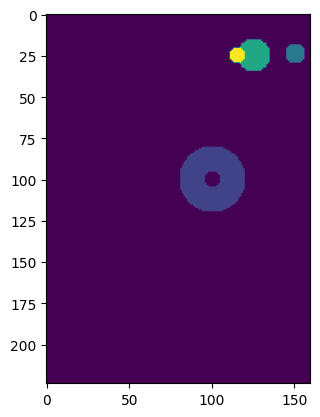

In [5]:
plt.imshow(image)

In [6]:
mp = F.max_pool2d(image.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1)

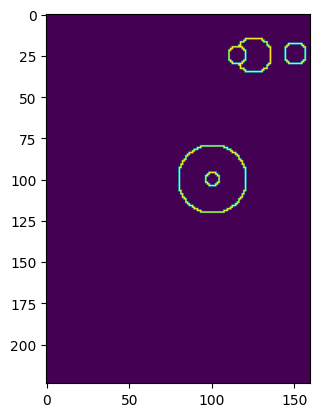

In [7]:
diff = (mp.squeeze() != image).type(torch.float32)
plt.imshow(mp.squeeze() != image)

In [8]:
mp2 = F.max_pool2d(diff.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1)

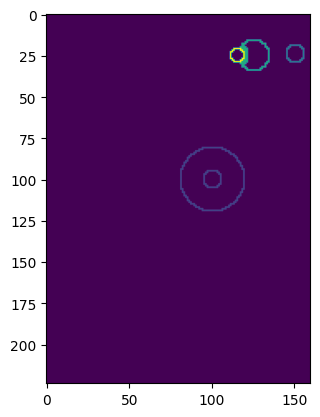

In [9]:
plt.imshow(mp2.squeeze() * image)

In [10]:
import torch.nn.functional as F
def edge_pixels(batched_image):
    dtype = batched_image.dtype # preserve original datatype for casting at the end
    batched_image = batched_image.type(torch.float32)
    
    max_pool = F.max_pool2d(batched_image, 3, stride=1, padding=1)
    outer_edge = (max_pool != batched_image).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * batched_image
    
    return inner_edge.type(dtype)
    

In [11]:
import torchvision.transforms.functional as TF
def closing(batched_image, n_steps):
    # this works as long as all the ids are positive
    
    dtype = batched_image.dtype # preserve original datatype for casting at the end
    batched_image = batched_image.type(torch.float32)
    dilated = batched_image
    dilated = F.pad(dilated, (n_steps*2, n_steps*2, n_steps*2, n_steps*2)) # it is essential to provide all padding at the start, otherwise we get wierd behaviour at the edges
    for _ in range(n_steps):
        dilated = F.max_pool2d(dilated, 3, stride=1, padding=0)
    
    eroded = (1 - dilated)
    for _ in range(n_steps):
        eroded = F.max_pool2d(eroded, 3, stride =1, padding=1)
        
    return TF.center_crop((1-eroded), batched_image.shape[-2:]).type(dtype)

def closing_old(batched_image, n_steps):
    # this works as long as all the ids are positive
    
    dtype = batched_image.dtype # preserve original datatype for casting at the end
    batched_image = batched_image.type(torch.float32)
    dilated = batched_image
    for _ in range(n_steps):
        dilated = F.max_pool2d(dilated, 3, stride=1, padding=1)
    
    eroded = (1 - dilated)
    for _ in range(n_steps):
        eroded = F.max_pool2d(eroded, 3, stride =1, padding=1)
        
    return (1-eroded).type(dtype)
    

torch.Size([1, 1, 224, 160])


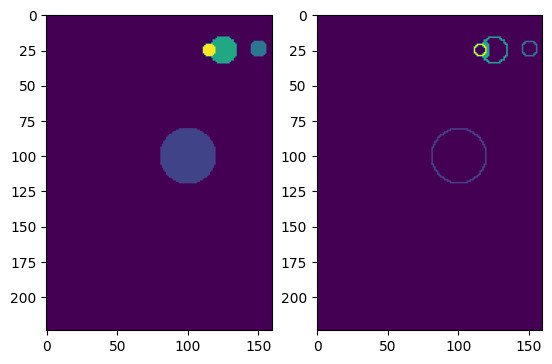

In [12]:
closed = closing(image.unsqueeze(0).unsqueeze(0), 4)
closed_old = closing_old(image.unsqueeze(0).unsqueeze(0), 4)
edges = edge_pixels(closed)
plt.subplot(1,2,1)
plt.imshow(closed.squeeze())
plt.subplot(1,2,2)
plt.imshow(edges.squeeze())
print(closed.shape)

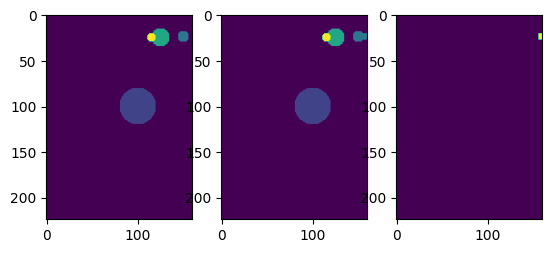

In [13]:
plt.subplot(1,3,1)
plt.imshow(closed.squeeze())
plt.subplot(1,3,2)
plt.imshow(closed_old.squeeze())
plt.subplot(1,3,3)
plt.imshow(closed.squeeze() != closed_old.squeeze())

In [14]:
def one_hot_encoded_image(image):
    return (image == image.unique().view(-1, 1, 1, 1))

In [15]:
one_hot = one_hot_encoded_image(edges)

In [16]:
wheres = torch.where(one_hot.squeeze())

In [17]:
wheres = [(wheres[1][wheres[0] == idx], wheres[2][wheres[0] == idx]) for idx in wheres[0].unique()]

In [18]:
wheres[0]

(tensor([  0,   0,   0,  ..., 223, 223, 223]),
 tensor([  0,   1,   2,  ..., 157, 158, 159]))

In [19]:
def get_edge_cords(image, closing_steps=5):
    """
    given a batch of images of shape [B, 1, H, W], containing instance segmentations, each instance has a unique ID.
    return for each element in the batch a list of x,y coordinates of the egde pixels of every istance in the image
    optionally perform closing to remove any holes in instances. Also returns the edge map for each image in the batch
    """
    bs = image.shape[0]
    
    # perform closing
    closed = closing(image, closing_steps)
    
    # get edge pixels
    edges = edge_pixels(closed)
    
    # for each image, find the locations of the pixels in the image
    batch_wheres = []
    for i in range(bs):
        one_hot_i = one_hot_encoded_image(edges[i].unsqueeze(0))
        wheres = torch.where(one_hot_i.squeeze()) # get location of instances
        wheres = [(wheres[1][wheres[0] == idx], wheres[2][wheres[0] == idx]) for idx in wheres[0].unique()] # convert to [(xs, ys) for each instance] form
        batch_wheres.append(wheres[1:]) # skip the 'wheres' for the background class
        
    return batch_wheres, edges
        
    

In [39]:
batch_image = torch.zeros(2, *spatial_dims)

In [40]:
batch_image[0,sphere(100, 100, 20)] = 1
batch_image[0,sphere(200, 5, 6)] = 2
batch_image[0,sphere(25, 125, 10)] = 3
batch_image[0,sphere(25, 115, 5)] = 4
batch_image[0,sphere(100, 100, 5)] = 0

batch_image[1,sphere(224-100, 160-100, 20)] = 1 + 4
batch_image[1,sphere(224-200, 160-10, 6)] = 2 + 4
batch_image[1,sphere(224-25, 160-125, 10)] = 3 + 4
batch_image[1,sphere(224-25, 160-115, 5)] = 4 + 4
batch_image[1,sphere(224-100, 160-100, 5)] = 0

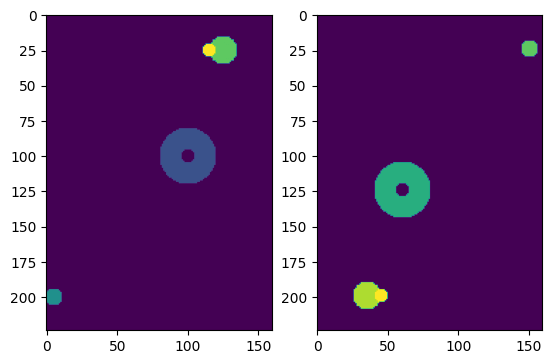

In [41]:
plt.subplot(1,2,1)
plt.imshow(batch_image[0])
plt.subplot(1,2,2)
plt.imshow(batch_image[1])

In [42]:
edge_coords, edge_map = get_edge_cords(batch_image.unsqueeze(1), 4)

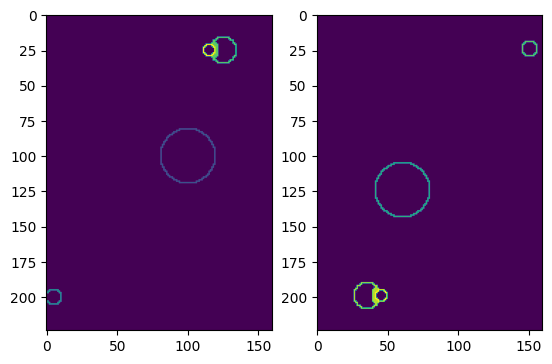

In [43]:
plt.subplot(1,2,1)
plt.imshow(edge_map[0].squeeze())
plt.subplot(1,2,2)
plt.imshow(edge_map[1].squeeze())

In [44]:
### entire batch at once version
def get_edge_cords_batch(image, closing_steps=5, unique_labels=False):
    """
    given a batch of images of shape [B, 1, H, W], containing instance segmentations, each instance has a unique ID.
    return for each element in the batch a list of x,y coordinates of the egde pixels of every istance in the image
    optionally perform closing to remove any holes in instances. Also returns the edge map for each image in the batch
    """
    bs = image.shape[0]
    
    # perform closing
    closed = closing(image, closing_steps)
    
    # get edge pixels
    edges = edge_pixels(closed)
    
    
    edge_flat = edges.flatten()
    instance_edge_locs = torch.where(edge_flat != 0)[0]
    instance_edge_values = edge_flat[instance_edge_locs]
    instance_ids = instance_edge_values.unique()
    
    shape = edges.shape
    print(shape)
    width = shape[-2]
    height = shape[-1]
    pixels = height * width
    
    batch_position = instance_edge_locs // pixels
    image_position = instance_edge_locs - (batch_position * pixels)
    row_position = image_position // height
    column_position = image_position % height
    
    batch_wheres = [[] for _ in range(bs)]
    for instance_id in instance_edge_values.unique():
        # instance_wheres = torch.where(per_instance_masks[i])
        instance_wheres = instance_edge_values == instance_id
        instance_batch = batch_position[instance_wheres]
        instance_rows = row_position[instance_wheres]
        instance_columns = column_position[instance_wheres]
        if unique_labels:
            batch_wheres[instance_batch[0]].append((instance_rows, instance_columns))
        else:
            for batch_idx in instance_batch.unique():
                batch_idx_loc = instance_batch == batch_idx
                batch_wheres[batch_idx].append((instance_rows[batch_idx_loc], instance_columns[batch_idx_loc]))
            
        
    return batch_wheres, edges

In [45]:
edge_coords2, edge_map = get_edge_cords_batch(batch_image.unsqueeze(1), closing_steps=5)

torch.Size([2, 1, 224, 160])


In [46]:
edge_coords[1][1]

(tensor([19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 23,
         23, 24, 24, 25, 25, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29,
         29, 29, 29, 29]),
 tensor([147, 148, 149, 150, 151, 152, 153, 146, 147, 153, 154, 145, 146, 154,
         155, 145, 155, 145, 155, 145, 155, 145, 155, 145, 155, 145, 146, 154,
         155, 146, 147, 153, 154, 147, 148, 149, 150, 151, 152, 153]))

In [47]:
edge_coords2[1][1]

(tensor([19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 23,
         23, 24, 24, 25, 25, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29,
         29, 29, 29, 29]),
 tensor([147, 148, 149, 150, 151, 152, 153, 146, 147, 153, 154, 145, 146, 154,
         155, 145, 155, 145, 155, 145, 155, 145, 155, 145, 155, 145, 146, 154,
         155, 146, 147, 153, 154, 147, 148, 149, 150, 151, 152, 153]))

In [48]:
n = 200
batch_image_big = torch.zeros(2*n, *spatial_dims)
batch_image_big[:n] = batch_image[0]
#batch_image_big[:n][batch_image_big[:n] != 0] +=  (torch.arange(0, n, 1).unsqueeze(-1).unsqueeze(-1) * 4)
batch_image_big[n:] = batch_image[1]
batch_image_big = batch_image_big.cuda()

In [30]:
import time

In [49]:
start = time.time()
edge_coords2, edge_map2 = get_edge_cords_batch(batch_image_big.unsqueeze(1), closing_steps=5, unique_labels=False)
end = time.time()
total1 = end - start
print(total1)
start = time.time()
edge_coords, edge_map = get_edge_cords(batch_image_big.unsqueeze(1), closing_steps=5)
end = time.time()
total2 = end - start
print(total2)
print(total2 / total1)

torch.Size([400, 1, 224, 160])
0.2606818675994873
0.5623071193695068
2.1570626470784604


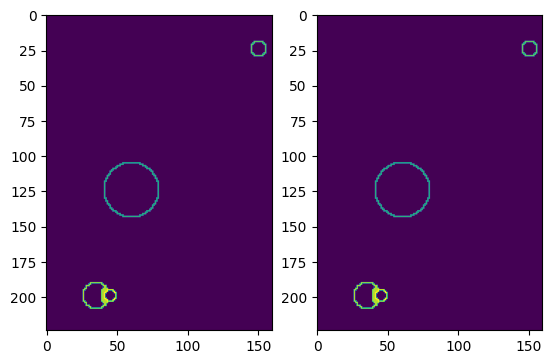

In [50]:
plt.subplot(1,2,1)
plt.imshow(edge_map2[200].squeeze().cpu())
plt.subplot(1,2,2)
plt.imshow(edge_map[200].squeeze().cpu())

In [51]:
edge_coords[200][0]

(tensor([105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106,
         106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 108, 108, 108,
         108, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 111, 111, 111,
         111, 112, 112, 113, 113, 113, 113, 114, 114, 114, 114, 115, 115, 116,
         116, 116, 116, 117, 117, 118, 118, 118, 118, 119, 119, 120, 120, 121,
         121, 122, 122, 123, 123, 124, 124, 125, 125, 126, 126, 127, 127, 128,
         128, 129, 129, 130, 130, 130, 130, 131, 131, 132, 132, 132, 132, 133,
         133, 134, 134, 134, 134, 135, 135, 135, 135, 136, 136, 137, 137, 137,
         137, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 140, 140, 140,
         140, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 143,
         143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143],
        device='cuda:0'),
 tensor([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 52, 53, 54, 66, 67,
         68, 50, 51, 52, 68, 69, 

In [52]:
edge_coords2[200][0]

(tensor([105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106,
         106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 108, 108, 108,
         108, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 111, 111, 111,
         111, 112, 112, 113, 113, 113, 113, 114, 114, 114, 114, 115, 115, 116,
         116, 116, 116, 117, 117, 118, 118, 118, 118, 119, 119, 120, 120, 121,
         121, 122, 122, 123, 123, 124, 124, 125, 125, 126, 126, 127, 127, 128,
         128, 129, 129, 130, 130, 130, 130, 131, 131, 132, 132, 132, 132, 133,
         133, 134, 134, 134, 134, 135, 135, 135, 135, 136, 136, 137, 137, 137,
         137, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 140, 140, 140,
         140, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 143,
         143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143],
        device='cuda:0'),
 tensor([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 52, 53, 54, 66, 67,
         68, 50, 51, 52, 68, 69, 

### combined code:

In [ ]:
import torchvision.transforms.functional as TF
import torch
import torch.nn.functional as F

def edge_pixels(batched_image):
    dtype = batched_image.dtype # preserve original datatype for casting at the end
    batched_image = batched_image.type(torch.float32)
    
    max_pool = F.max_pool2d(batched_image, 3, stride=1, padding=1)
    outer_edge = (max_pool != batched_image).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * batched_image
    
    return inner_edge.type(dtype)

def closing(batched_image, n_steps):
    # this works as long as all the ids are positive
    
    dtype = batched_image.dtype # preserve original datatype for casting at the end
    batched_image = batched_image.type(torch.float32)
    dilated = batched_image
    dilated = F.pad(dilated, (n_steps*2, n_steps*2, n_steps*2, n_steps*2)) # it is essential to provide all padding at the start, otherwise we get wierd behaviour at the edges
    for _ in range(n_steps):
        dilated = F.max_pool2d(dilated, 3, stride=1, padding=0)
    
    eroded = (1 - dilated)
    for _ in range(n_steps):
        eroded = F.max_pool2d(eroded, 3, stride =1, padding=1)
        
    return TF.center_crop((1-eroded), batched_image.shape[-2:]).type(dtype)

### entire batch at once version
def get_edge_cords_batch(image, closing_steps=5, unique_labels=False):
    """
    given a batch of images of shape [B, 1, H, W], containing instance segmentations, each instance has a unique ID.
    return for each element in the batch a list of x,y coordinates of the egde pixels of every istance in the image
    optionally perform closing to remove any holes in instances. Also returns the edge map for each image in the batch
    """
    bs = image.shape[0]
    
    # perform closing
    closed = closing(image, closing_steps)
    
    # get edge pixels
    edges = edge_pixels(closed)
    
    
    edge_flat = edges.flatten()
    instance_edge_locs = torch.where(edge_flat != 0)[0]
    instance_edge_values = edge_flat[instance_edge_locs]
    instance_ids = instance_edge_values.unique()
    
    shape = edges.shape
    print(shape)
    width = shape[-2]
    height = shape[-1]
    pixels = height * width
    
    batch_position = instance_edge_locs // pixels
    image_position = instance_edge_locs - (batch_position * pixels)
    row_position = image_position // height
    column_position = image_position % height
    
    batch_wheres = [[] for _ in range(bs)]
    for instance_id in instance_edge_values.unique():
        # instance_wheres = torch.where(per_instance_masks[i])
        instance_wheres = instance_edge_values == instance_id
        instance_batch = batch_position[instance_wheres]
        instance_rows = row_position[instance_wheres]
        instance_columns = column_position[instance_wheres]
        if unique_labels:
            batch_wheres[instance_batch[0]].append((instance_rows, instance_columns))
        else:
            for batch_idx in instance_batch.unique():
                batch_idx_loc = instance_batch == batch_idx
                batch_wheres[batch_idx].append((instance_rows[batch_idx_loc], instance_columns[batch_idx_loc]))
            
        
    return batch_wheres, edges

def one_hot_encoded_image(image):
    # for a 2D [H, W] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1))